In [921]:
%matplotlib inline
import mmqdata as m
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import pandas as pd
import numpy as np
import math
import warnings
from collections import Counter

In [922]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    po_pbp = m.csv_to_df('data\playbyplaydata\[po]*')
    rs_pbp = m.csv_to_df('data\playbyplaydata\[rs]*')

In [923]:
run_df = po_pbp[po_pbp.PlayType == 'Run'][\
['Season',
 'GameID',
 'posteam',
 'TimeSecs',
 'Rusher',
 'RunLocation',
 'yrdline100',
 'Yards.Gained',
 'Touchdown']
].reset_index(drop=True)

# HeatMap Code

In [924]:
def makePassDF(playoffs=False):
    # Create passing data DataFrame
    if playoffs:
        df = po_pbp.copy()
    else:
        df = rs_pbp.copy()
    
    pass_df = df[df.PlayType == 'Pass'][\
    ['Season',
     'GameID',
     'posteam',
     'TimeSecs',
     'Passer',
     'Receiver',
     'yrdline100',
     'AirYards',
     'YardsAfterCatch',
     'Yards.Gained',
     'PassLength',
     'PassOutcome',
     'PassLocation',
     'InterceptionThrown',
     'Touchdown']
    ].reset_index(drop=True)

    def completionFilter(row):
        if row.PassOutcome == 'Incomplete Pass':
            if row.InterceptionThrown == 1:
                return 'Interception'
            else:
                return 'Incomplete'
        else:
            return 'Complete'

    pass_df.PassOutcome = pass_df.apply(completionFilter,axis=1)
    pass_df['ReceiveYrdLine100'] = pass_df.yrdline100 - pass_df.AirYards
    
    return pass_df

In [925]:
# Setup Masking Function
# https://stackoverflow.com/questions/11869910/pandas-filter-rows-of-dataframe-with-operator-chaining
def mask(df, key, value, operator='=='):
    if type(value) is list:
        if operator == 'not':
            return df[df[key].apply(lambda x: x not in value)]
        else:
            return df[df[key].apply(lambda x: x in value)]
    else:
        if operator == '!=':
            return df[df[key] != value]
        elif operator == '>':
            return df[df[key] > value]
        elif operator == '>=':
            return df[df[key] >= value]
        elif operator == '<':
            return df[df[key] < value]
        elif operator == '<=':
            return df[df[key] <= value]
        else:
            return df[df[key] == value]

# Set Pandas DF Mask funciton
pd.DataFrame.mask = mask

In [926]:
def compress_field(field, yards_in_group):
    # Group pass count data into sections of the field vs yard by yard
    items_in_group = yards_in_group * 3
    new_field = np.empty(((100//yards_in_group) * 3 + 3,3),dtype='object')
    current_yardline = yards_in_group
    pass_location = ['left', 'middle', 'right']
    count_summation = [0, 0, 0]
    new_field_index = 3

    for a in range(3):
        new_field[0 + a][0] = 0
        new_field[0 + a][1] = pass_location[a]
        new_field[0 + a][2] = field[0 + a][2]

    for i in range(3,300):
        count_summation[i%3] += field[i][2]
        if ((i - 3) % items_in_group == items_in_group - 1) or (i == 299):
            for j in range(3):
                new_field[new_field_index + j][0] = current_yardline
                new_field[new_field_index + j][1] = pass_location[j]
                new_field[new_field_index + j][2] = count_summation[j]
            new_field_index += 3
            current_yardline += yards_in_group
            count_summation = [0, 0, 0]
    return new_field

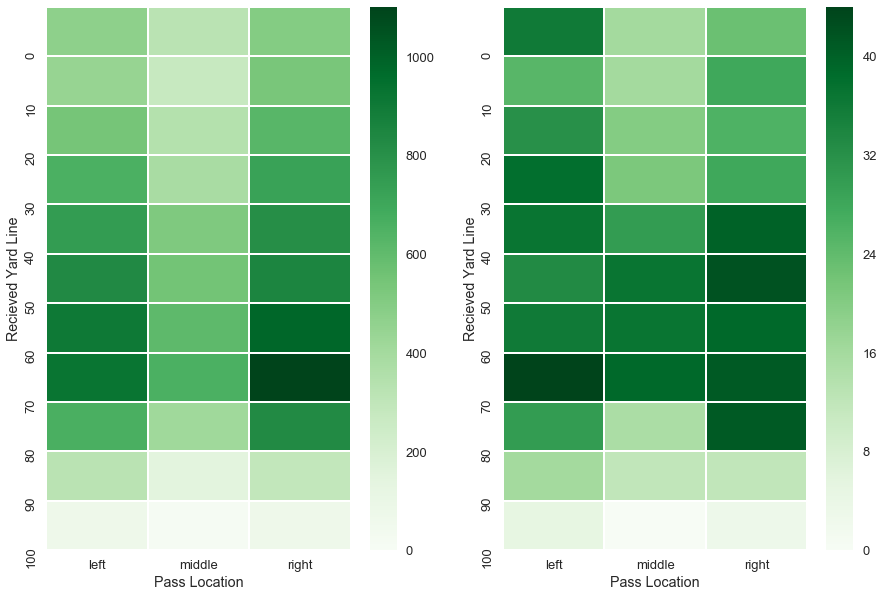

In [927]:
filters=[
    ['Season', 2016]
]

yard_grouping = 10

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
plotPassingHeatMap(playoffs=False, filters=filters, ax=ax1, yard_grouping=yard_grouping)
plotPassingHeatMap(playoffs=True, filters=filters, ax=ax2, yard_grouping=yard_grouping)
plt.show()

In [928]:
def plotPassingHeatMap(playoffs=False, throw_or_catch_yrdline='catch', filters=[], yard_grouping=5, 
                       vmin=0, vmax=None, annot=False, cmap='Greens', cbar=True, cbar_ax=None, ax=None):
    
    # Create passing data DataFrame
    pass_df = makePassDF(playoffs)
    
    # Run any provided filters
    if len(filters) > 0:
        for f in filters:
            if len(f) == 2:
                pass_df = pass_df.mask(f[0], f[1])
            else:
                pass_df = pass_df.mask(f[0], f[1], f[3])
                
    #pass_results_df = pass_df.mask('PassOutcome','Interception').mask('ReceiveYrdLine100', 0, '>=')
    
    # Group data by throw or catch location:
    if throw_or_catch_yrdline == 'throw':
        throw_or_catch_string = 'yrdline100'
        y_label = 'QB Throw Yard Line'
    else:
        throw_or_catch_string = 'ReceiveYrdLine100'
        y_label = 'Recieved Yard Line'
    pass_results_df = pass_df.groupby([throw_or_catch_string,'PassLocation']).agg({'GameID':len}).reset_index()
    
    # Build numpy array representing the football field to structure the heatmap and populate the counts
    field = np.empty((300,3),dtype='object')
    yardline = 0
    pass_location = ['left','middle','right']
    for row in range(0,300):
        field[row][0] = yardline
        field[row][1] = pass_location[row%3]
        temp = pass_results_df.mask(throw_or_catch_string, yardline).mask('PassLocation', field[row][1]).values
        if temp.shape[0] > 0:
            field[row][2] = temp[0][2]
        else:
            field[row][2] = 0
        if row%3 == 2:
            yardline += 1
    
    # Group the count data based on the 'yard_grouping' parameter
    if yard_grouping > 1:
        field = compress_field(field, yard_grouping)
    
    # Create a seaborn.heatmap() ready dataframe
    heat_map_df = pd.DataFrame.from_records(field,
                columns=[y_label, 'Pass Location', 'Count']
                ).pivot(y_label, 'Pass Location','Count')
    
    #with sns.axes_style("ticks"):
    #fig,ax1 = plt.subplots(1,1,figsize=figsize)
    ax = sns.heatmap(data=heat_map_df, cmap=cmap, square=False, linewidths=1, linecolor='white', annot=annot, fmt="d", vmin=vmin, vmax=vmax, cbar=True, cbar_ax=None, ax=ax)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks([x for x in range(0,int(100 / yard_grouping) + 1)])
    
    return ax


    

In [929]:
# Make an Interception Play type for any 'Pass' PlayType that has a positive 'InterceptionThrown' attribute
po_pbp['Testing'] = po_pbp.apply(lambda x: 'Interception' if (x.InterceptionThrown == 1) and (x.PlayType=='Pass') else x['PlayType'],axis=1)
Counter(po_pbp.Testing)


Counter({'End of Game': 81,
         'Extra Point': 495,
         'Field Goal': 333,
         'Interception': 202,
         'Kickoff': 989,
         'No Play': 705,
         'Pass': 6735,
         'Punt': 806,
         'QB Kneel': 159,
         'Quarter End': 186,
         'Run': 4880,
         'Sack': 435,
         'Spike': 29,
         'Timeout': 697,
         'Two Minute Warning': 144})

In [930]:
def match(playtype):
    valid_play_types = [
        'Field Goal',
        'Pass',
        'Run',
        'QB Kneel',
        'Punt',
        'Extra Point',
        'Sack',
        'Spike',
        'Timeout'
    ]
    return playtype in valid_play_types


def condense_pbp_data(df):
    new_df = df[['qtr', 'down', 'TimeUnder','TimeSecs', 'yrdline100', 'ScoreDiff', 'PlayType','Season']]
    new_df = new_df[new_df.PlayType.map(match)]
    new_df = new_df[new_df['down'].isnull()==False]
    return new_df

In [931]:
playoffs = condense_pbp_data(po_pbp)
regular = condense_pbp_data(rs_pbp)

In [932]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [933]:
sns.set_style("whitegrid")

In [934]:
def makeDF(season=2009):
    rdf = regular[regular.Season==season]
    rdf = rdf.groupby('PlayType').agg({'qtr':len}).reset_index()
    rdf.columns = ['PlayType', 'Count']
    rdf['Percent Total'] = rdf.Count/rdf.Count.sum()*100
    rdf['ID'] = 'Regular'
    
    pdf = playoffs[playoffs.Season==season]
    pdf = pdf.groupby('PlayType').agg({'qtr':len}).reset_index()
    pdf.columns = ['PlayType', 'Count']
    pdf['Percent Total'] = pdf.Count/pdf.Count.sum()*100
    pdf['ID'] = 'Playoffs'
    
    x = rdf.append(pdf, ignore_index=True)
    fig, ax1 = plt.subplots(1,1,figsize=(12,10))
    sns.barplot(ax=ax1, data=x, y='PlayType', x='Percent Total',hue='ID', order=['Pass', 'Run', 'Punt', 'Field Goal', 'QB Kneel'])
    ax1.set_xlim(0,60)

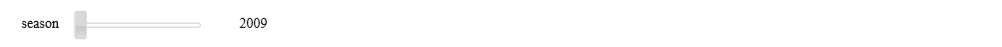

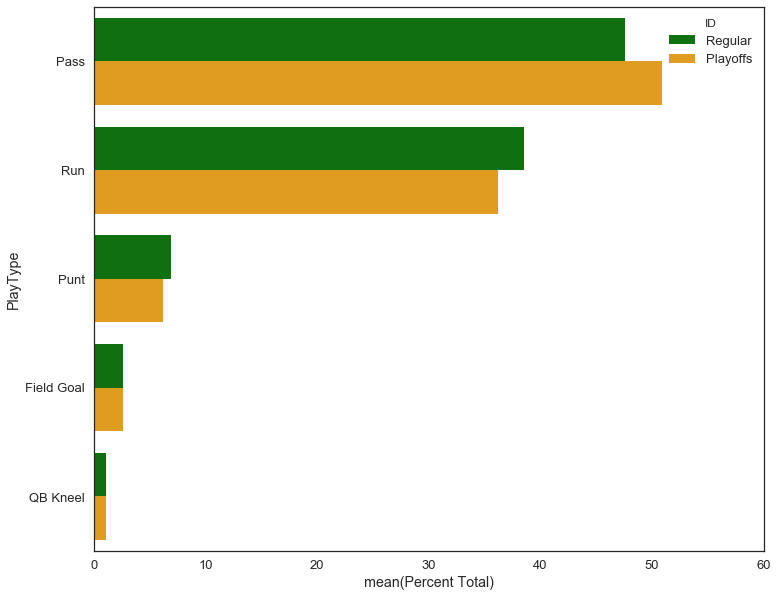

In [935]:
w = interactive(makeDF,season=widgets.IntSlider(min=2009,max=2016,step=1,value=2009,continuous_update=False))
w

In [936]:
#Set general plot properties
sns.set_style("white", {"axes.grid": True})
sns.set_context({"figure.figsize": (10, 7)})


In [937]:
def plot_PlayType(df,stat,playtypelist=['Pass','Run','Field Goal','QB Kneel','Punt'],percent_total=False):
    g = df.groupby([stat,'PlayType']).count().reset_index()
    g = g[g.columns[0:3]]
    last_col_name = g.columns[-1]
    g1 = g.groupby([stat, 'PlayType']).agg({last_col_name: 'sum'})
    if percent_total:
        g1 = g1.groupby(level=1).apply(lambda x: 100 * x / float(x.sum()))
    g1 = g1.reset_index()
    g1 = g1[g1.PlayType.apply(lambda x: x in playtypelist)]
    return sns.barplot(x=stat, y=last_col_name, hue="PlayType", data=g1)

In [938]:
sns.set_style('whitegrid')
sns.set_palette(['blue', 'green','red'])

(0, 0.09)

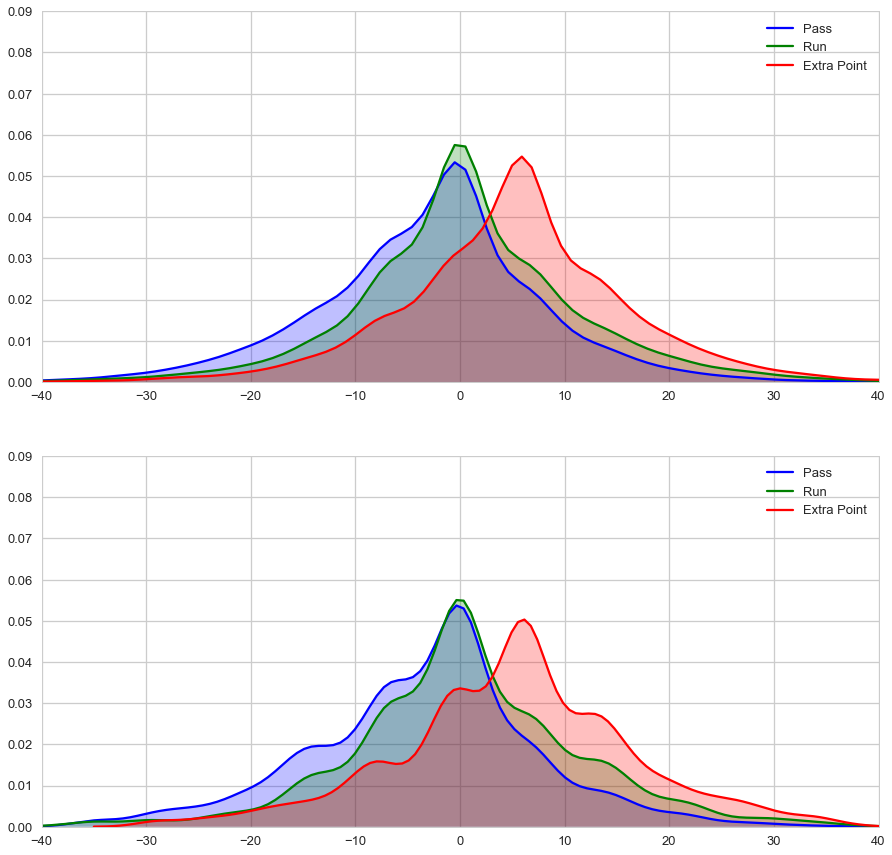

In [939]:
fig, axes = plt.subplots(2, 1, figsize=(15,15))
shade = True
bw = '2'

sns.kdeplot(ax=axes[0],data=rs_pbp[rs_pbp.PlayType == 'Pass'].ScoreDiff.dropna(),label='Pass',shade=shade,bw=bw)
sns.kdeplot(ax=axes[0],data=rs_pbp[rs_pbp.PlayType == 'Run'].ScoreDiff.dropna(),label='Run',shade=shade,bw=bw)
sns.kdeplot(ax=axes[0],data=rs_pbp[rs_pbp.PlayType == 'Extra Point'].ScoreDiff.dropna(),label='Extra Point',shade=shade,bw=bw)

axes[0].set_xlim(-40,40)
axes[0].set_ylim(0,0.09)

sns.kdeplot(ax=axes[1],data=po_pbp[po_pbp.PlayType == 'Pass'].ScoreDiff.dropna(),label='Pass',shade=shade,bw=bw)
sns.kdeplot(ax=axes[1],data=po_pbp[po_pbp.PlayType == 'Run'].ScoreDiff.dropna(),label='Run',shade=shade,bw=bw)
sns.kdeplot(ax=axes[1],data=po_pbp[po_pbp.PlayType == 'Extra Point'].ScoreDiff.dropna(),label='Extra Point',shade=shade,bw=bw)

axes[1].set_xlim(-40,40)
axes[1].set_ylim(0,0.09)
#SMOOTH IT OUT!


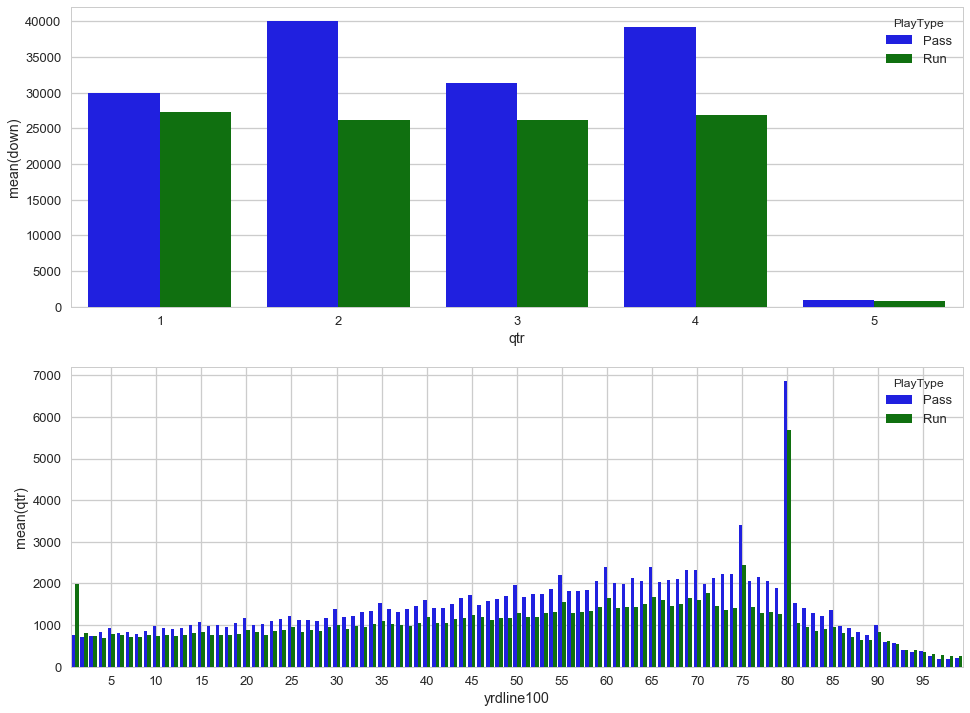

In [940]:
fig = plt.figure(figsize=(16,32))

ax3 = fig.add_subplot(513)
ax3 = plot_PlayType(regular,'qtr',['Run','Pass'],False)

ax4 = fig.add_subplot(514)
ax4 = plot_PlayType(regular,'yrdline100',['Run','Pass'],False)
ax4.xaxis.set_ticks(range(4, 99, 5))
ax4.xaxis.set_ticklabels(range(5,100,5))
ax4.grid(True,'major','both')



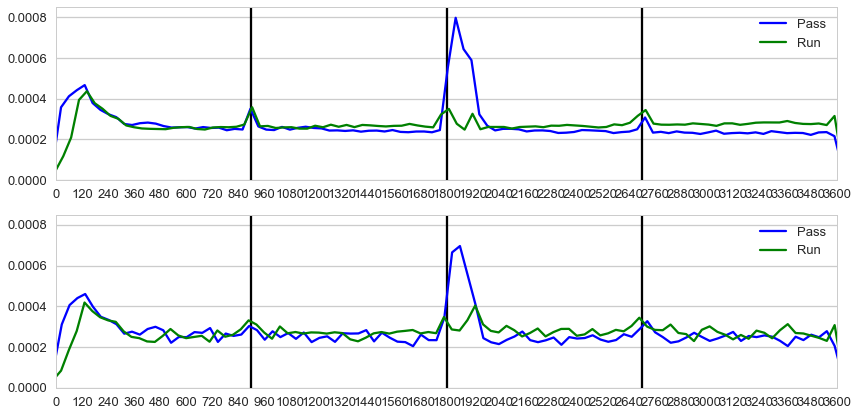

In [941]:
fig, axes = plt.subplots(2,1,figsize=(14,7))
sns.kdeplot(ax=axes[0],data=regular[regular.PlayType == 'Pass'].TimeSecs,bw=20,label='Pass')
sns.kdeplot(ax=axes[0],data=regular[regular.PlayType == 'Run'].TimeSecs,bw=20,label='Run')
loc = plticker.MultipleLocator(base=120.0) # this locator puts ticks at regular intervals
axes[0].xaxis.set_major_locator(loc)
axes[0].set_xlim(0,3600)
axes[0].set_ylim(0,0.00085)
axes[0].vlines([x*60 for x in [15,30,45]],0,0.0009,colors='black')
axes[0].grid(True,'major','y')
axes[0].grid(False,'major','x')

sns.kdeplot(ax=axes[1],data=playoffs[playoffs.PlayType == 'Pass'].TimeSecs,bw=20,label='Pass')
sns.kdeplot(ax=axes[1],data=playoffs[playoffs.PlayType == 'Run'].TimeSecs,bw=20,label='Run')
loc = plticker.MultipleLocator(base=120.0) # this locator puts ticks at regular intervals
axes[1].xaxis.set_major_locator(loc)
axes[1].set_xlim(0,3600)
axes[1].set_ylim(0,0.00085)
axes[1].vlines([x*60 for x in [15,30,45]],0,0.0009,colors='black')
axes[1].grid(True,'major','y')
axes[1].grid(False,'major','x')

## Field Goal Data  
**Regular Season**

In [942]:
rs_fg = rs_pbp[rs_pbp.PlayType =='Field Goal'].groupby('FieldGoalResult').agg({'Date':len}).reset_index()
rs_fg.columns=['FieldGoalResult', 'Count']
rs_fg['Percent Total'] = rs_fg.Count.apply(lambda x: 100 * x / float(rs_fg.Count.sum()))

po_fg = po_pbp[po_pbp.PlayType =='Field Goal'].groupby('FieldGoalResult').agg({'Date':len}).reset_index()
po_fg.columns=['FieldGoalResult', 'Count']
po_fg['Percent Total'] = po_fg.Count.apply(lambda x: 100 * x / float(po_fg.Count.sum()))


In [943]:
sns.set_palette(['green', 'orange', 'red'])

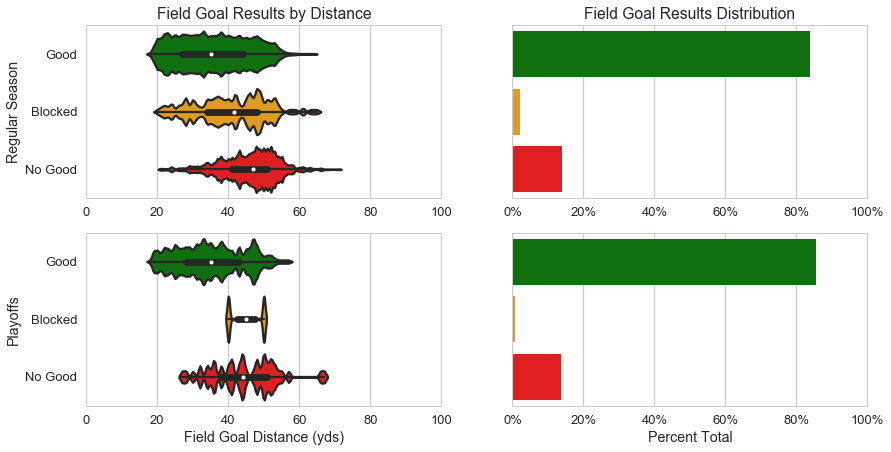

In [944]:
fig, axes = plt.subplots(2, 2,sharey=True,figsize=(14,7))
order = ['Good','Blocked','No Good']

sns.violinplot(ax=axes[0][0], data=rs_pbp[rs_pbp.PlayType=='Field Goal'], x='FieldGoalDistance', y='FieldGoalResult',order=order, scale='width', bw=0.05)
sns.violinplot(ax=axes[1][0], data=po_pbp[po_pbp.PlayType=='Field Goal'], x='FieldGoalDistance', y='FieldGoalResult',order=order, scale='width', bw=0.05)
axes[0][0].set_xlim(0,100)
axes[1][0].set_xlim(0,100)

sns.barplot(ax=axes[0][1], data=rs_fg,y='FieldGoalResult', x='Percent Total',order=order)
sns.barplot(ax=axes[1][1], data=po_fg,y='FieldGoalResult', x='Percent Total',order=order)
axes[0][1].set_xlim(0,100)
axes[1][1].set_xlim(0,100)

axes[0][1].set_xticklabels(['0%','20%','40%','60%','80%','100%'])
axes[1][1].set_xticklabels(['0%','20%','40%','60%','80%','100%'])


axes[0][0].set_title('Field Goal Results by Distance')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('Regular Season')

axes[0][1].set_title('Field Goal Results Distribution')
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('')

axes[1][0].set_ylabel('Playoffs')
axes[1][0].set_xlabel('Field Goal Distance (yds)')
axes[1][0].figure

axes[1][1].set_ylabel('')
axes[1][1].set_xlabel('Percent Total')


### Pass/Run per team per season


In [976]:
teams = [['ARI', 'Arizona', 'Cardinals', 'Arizona Cardinals'],
 ['ATL', 'Atlanta', 'Falcons', 'Atlanta Falcons'],
 ['BAL', 'Baltimore', 'Ravens', 'Baltimore Ravens'],
 ['BUF', 'Buffalo', 'Bills', 'Buffalo Bills'],
 ['CAR', 'Carolina', 'Panthers', 'Carolina Panthers'],
 ['CHI', 'Chicago', 'Bears', 'Chicago Bears'],
 ['CIN', 'Cincinnati', 'Bengals', 'Cincinnati Bengals'],
 ['CLE', 'Cleveland', 'Browns', 'Cleveland Browns'],
 ['DAL', 'Dallas', 'Cowboys', 'Dallas Cowboys'],
 ['DEN', 'Denver', 'Broncos', 'Denver Broncos'],
 ['DET', 'Detroit', 'Lions', 'Detroit Lions'],
 ['GB', 'Green Bay', 'Packers', 'Green Bay Packers', 'G.B.', 'GNB'],
 ['HOU', 'Houston', 'Texans', 'Houston Texans'],
 ['IND', 'Indianapolis', 'Colts', 'Indianapolis Colts'],
 ['JAC', 'Jacksonville', 'Jaguars', 'Jacksonville Jaguars', 'JAX'],
 ['KC', 'Kansas City', 'Chiefs', 'Kansas City Chiefs', 'K.C.', 'KAN'],
 ['LA', 'Los Angeles', 'Rams', 'Los Angeles Rams', 'L.A.'],
 ['MIA', 'Miami', 'Dolphins', 'Miami Dolphins'],
 ['MIN', 'Minnesota', 'Vikings', 'Minnesota Vikings'],
 ['NE', 'New England', 'Patriots', 'New England Patriots', 'N.E.', 'NWE'],
 ['NO', 'New Orleans', 'Saints', 'New Orleans Saints', 'N.O.', 'NOR'],
 ['NYG', 'Giants', 'New York Giants', 'N.Y.G.'],
 ['NYJ', 'Jets', 'New York Jets', 'N.Y.J.'],
 ['OAK', 'Oakland', 'Raiders', 'Oakland Raiders'],
 ['PHI', 'Philadelphia', 'Eagles', 'Philadelphia Eagles'],
 ['PIT', 'Pittsburgh', 'Steelers', 'Pittsburgh Steelers'],
 ['SD', 'San Diego', 'Chargers', 'San Diego Chargers', 'S.D.', 'SDG'],
 ['SEA', 'Seattle', 'Seahawks', 'Seattle Seahawks'],
 ['SF', 'San Francisco', '49ers', 'San Francisco 49ers', 'S.F.', 'SFO'],
 ['STL', 'St. Louis', 'Rams', 'St. Louis Rams', 'S.T.L.'],
 ['TB', 'Tampa Bay', 'Buccaneers', 'Tampa Bay Buccaneers', 'T.B.', 'TAM'],
 ['TEN', 'Tennessee', 'Titans', 'Tennessee Titans'],
 ['WAS', 'Washington', 'Redskins', 'Washington Redskins', 'WSH']]

In [1362]:
teams_dict = {x[3]:x[0] for x in teams}

In [1363]:
# Jacksonville Data Fix
rs_pbp.posteam = rs_pbp.posteam.replace('JAX', 'JAC')
rs_pbp.HomeTeam = rs_pbp.HomeTeam.replace('JAX', 'JAC')
rs_pbp.AwayTeam = rs_pbp.AwayTeam.replace('JAX', 'JAC')

In [1364]:
pass_rush_attempts_by_team = rs_pbp.groupby(['posteam','Season']).agg(sum)[['PassAttempt','RushAttempt']]

In [1365]:
pass_rush_attempts_by_team['PassRushRatio'] = pass_rush_attempts_by_team.apply(lambda x: (x.PassAttempt * 1.0) / x.RushAttempt, axis=1)

In [1379]:
sns.set_palette('muted')
plot_df = pass_rush_attempts_by_team
plot_teams = teams_dict

def plotPassRushByTeam(team_focus_1, team_focus_2):
    for team in plot_teams:
        if (plot_teams[team] != team_focus_1) or (plot_teams[team] != team_focus_1):
            plt.plot(plot_df.loc[plot_teams[team]]['PassRushRatio'],color='0.91')
    plt.plot(plot_df.loc[team_focus_1]['PassRushRatio'],color='Blue')
    plt.plot(plot_df.loc[team_focus_2]['PassRushRatio'],color='Red')


In [1385]:
select_widget_1 = widgets.Select(
                options=teams_dict,
                description='Team 1:',
                disabled=False)

select_widget_2 = widgets.Select(
                options=teams_dict,
                description='Team 2:',
                disabled=False)

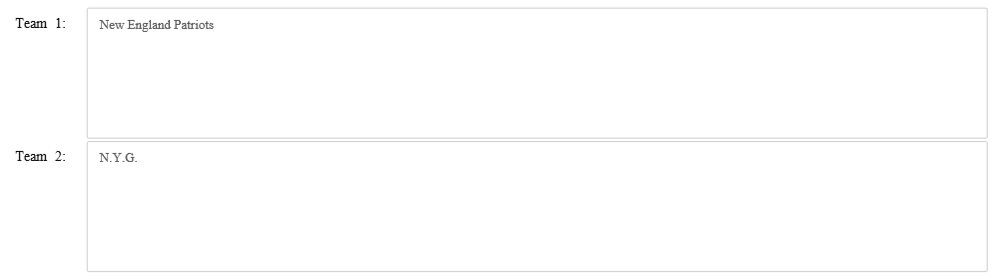

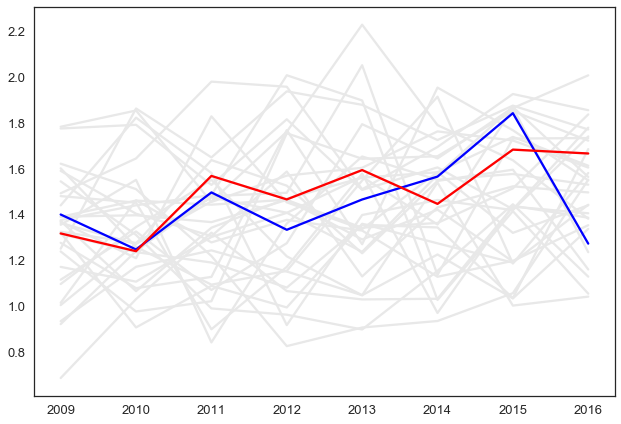

In [1386]:
w = interactive(plotPassRushByTeam, team_focus_1 = select_widget_1, team_focus_2 = select_widget_2)
w

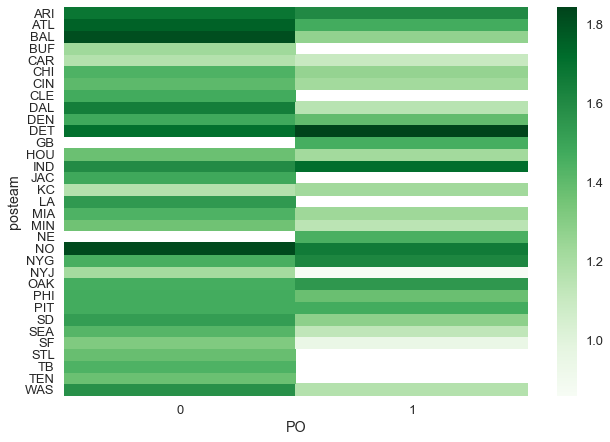

In [1297]:
sns.set_context('talk')
#sns.heatmap(data = pass_rush_attempts_by_team.reset_index().pivot('posteam','PO','PassRushRatio'),
#            vmin=0,vmax=1,square=False,cmap='rainbow', annot=False)

new_df = pass_rush_attempts_by_team.reset_index().groupby(['posteam','PO']).agg({'PassRushRatio':np.mean}).reset_index().pivot('posteam','PO','PassRushRatio')
sns.heatmap(data = new_df, square=False, annot=False, cmap='Greens')

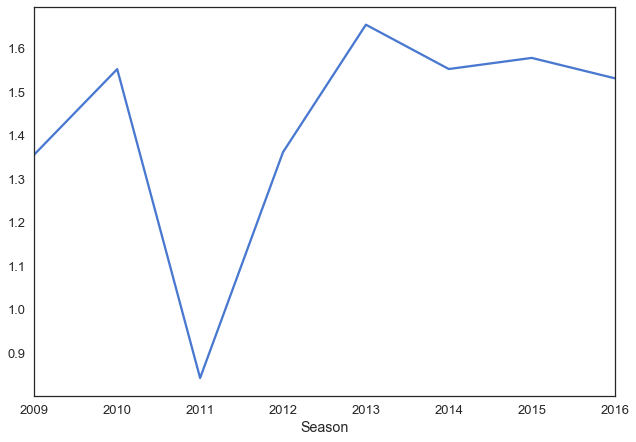

In [1298]:
sns.pointplot
pass_rush_attempts_by_team.loc['DEN']['PassRushRatio'].plot()

In [1110]:
from pprint import pprint

In [1121]:
pprint(Counter(rs_pbp.mask('posteam', 'DEN').mask('Season', 2014).mask('PlayType','Pass').Passer))

Counter({'P.Manning': 598, 'B.Osweiler': 10, nan: 1})


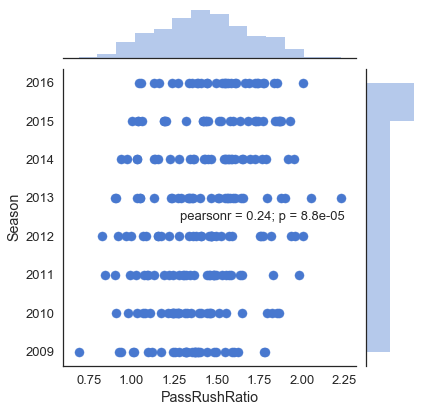

In [1197]:
sns.jointplot(data=pass_rush_attempts_by_team.reset_index(level=1),x='PassRushRatio',y='Season',)


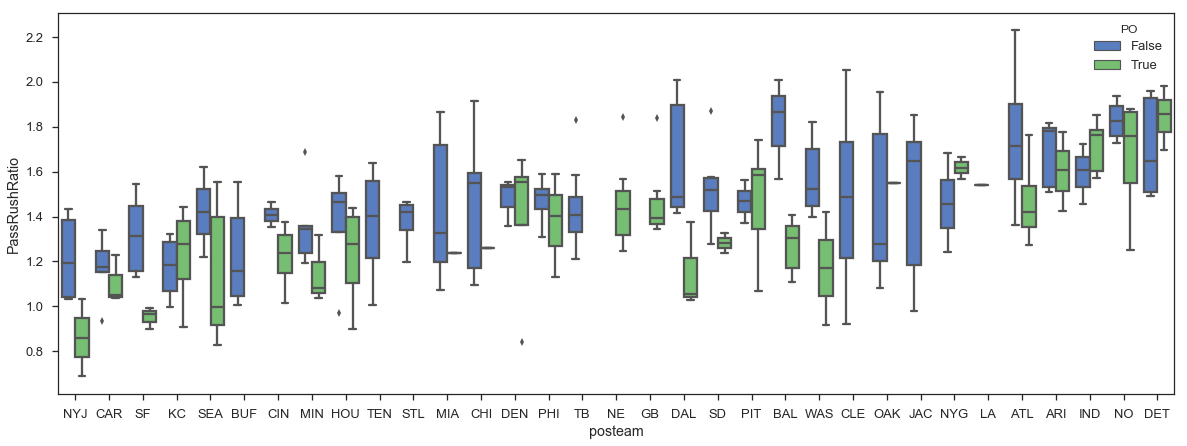

In [1243]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(20,7))
    sns.boxplot(data=pass_rush_attempts_by_team.reset_index(),x='posteam', y='PassRushRatio', ax=ax, order=avg_prr_by_team.index.tolist(),hue='PO')

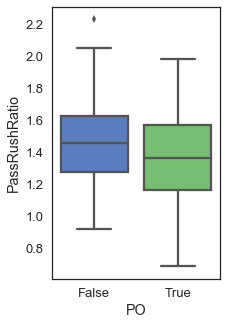

In [1256]:
fig, ax = plt.subplots(1,1,figsize=(3,5))
sns.boxplot(data=pass_rush_attempts_by_team.reset_index(),x='PO', y='PassRushRatio', ax=ax)


In [1216]:
avg_prr_by_team = pass_rush_attempts_by_team.reset_index().groupby('posteam').agg({'PassRushRatio':np.mean}).sort_values('PassRushRatio')
avg_prr_by_season = pass_rush_attempts_by_team.reset_index().groupby('Season').agg({'PassRushRatio':np.mean}).sort_values('PassRushRatio')

In [1221]:
avg_prr_by_team.index.tolist()

['NYJ',
 'CAR',
 'SF',
 'KC',
 'SEA',
 'BUF',
 'CIN',
 'MIN',
 'HOU',
 'TEN',
 'STL',
 'MIA',
 'CHI',
 'DEN',
 'PHI',
 'TB',
 'NE',
 'GB',
 'DAL',
 'SD',
 'PIT',
 'BAL',
 'WAS',
 'CLE',
 'OAK',
 'JAC',
 'NYG',
 'LA',
 'ATL',
 'ARI',
 'IND',
 'NO',
 'DET']

In [1239]:
playoff_teams = {year:po_pbp.mask('Season',year).posteam.dropna().unique().tolist() for year in np.arange(2009,2017,1)}

In [1263]:
def madeit(row):
    team, season = row.name
    return int(team in playoff_teams[season])

In [1264]:
pass_rush_attempts_by_team['PO'] = pass_rush_attempts_by_team.apply(madeit, axis=1)

In [1287]:
pass_rush_attempts_by_team.reset_index().groupby(['posteam','PO']).agg({'PassRushRatio':np.mean}).reset_index().pivot('posteam','PO','PassRushRatio')

PO,0,1
posteam,,
ARI,1.685654,1.602482
ATL,1.755601,1.469212
BAL,1.813270,1.270159
BUF,1.231704,NaN
CAR,1.169052,1.103865
CHI,1.441152,1.260101
CIN,1.408937,1.222294
CLE,1.475057,NaN
DAL,1.650238,1.153931
